In [38]:
#Importing Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import ConvLSTM2D
from keras.layers import Flatten
from numpy import array

In [102]:
#Import Raw Data and convert it to CSV 

url = "https://raw.githubusercontent.com/rohitash-chandra/CMTL_dynamictimeseries/master/IndianOcean/rawtrain1985-2001.txt"
df = pd.read_csv(url, sep = "\t", header = None)
df.columns = ['ID','Date','Longitude','Latitude','Speed']
df['Category'] = df['Speed'].apply(lambda x: 1 if x<=27 else 2  if x<=33 and x> 27 else 3 if x<=47 and x> 33 else 4 if x<=63 and x> 47 else 5 if x<=89 and x> 63 else 6 if x<=119 and x>89 else 7 )
df = df.drop(['Date'], axis = 1)
df.to_csv('adjusted.csv')



In [62]:
# Using a Univariate LSTM, therefore only working with Speed 

# Extracting speed data from Dataset 

speed = array(df['Speed'])
speed=speed.reshape(len(speed),1)
category=array(df['Category'])
speed

array([[20],
       [20],
       [25],
       ...,
       [35],
       [30],
       [25]], dtype=int64)

In [67]:
def cat_calc(tsd): 
    output=np.empty(len(tsd))
    for i in range(len(tsd)):
        if tsd[i]<=27:
            output[i]=1
        elif tsd[i]>27 and tsd[i]<=33:
            output[i]=2
        elif tsd[i]>33 and tsd[i]<=47:
            output[i]=3
        elif tsd[i]>47 and tsd[i]<=63:
            output[i]=4
        elif tsd[i]>63 and tsd[i]<=89:
            output[i]=5
        elif tsd[i]>89 and tsd[i]<=119:
            output[i]=6
        else:
            output[i]=7
    return output

In [70]:
# Splitting the Sequence To Prepare the Training and Test Data. Data Preprocessing. 

def split_seq(timeseries_data, n_steps_in, n_steps_out):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix+n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(timeseries_data)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [78]:
# Initialising Features of LSTM 

n_steps_in=4
n_features = 1
n_steps_out=1

In [79]:
# Defining RMSE Function to test Performance

def rmse(pred, actual):
    temp = np.sqrt(((pred-actual)**2).mean())
    return temp

In [80]:
# From Speed DataFrame, Separate and Prepare (Split and make 3D) Test and Train Data 

train = speed[0:9000]
test = speed[9000:9364]

x_train, y_train = split_seq(train, n_steps_in,n_steps_out)
x_test, y_test = split_seq(test, n_steps_in,n_steps_out)


x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
print(x_train.shape)

x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
print(x_test.shape)

y_train = y_train.reshape((y_train.shape[0], y_train.shape[1]))
print(y_train.shape)

y_test = y_test.reshape((y_test.shape[0], y_test.shape[1]))
print(y_test.shape)

(8995, 4, 1)
(359, 4, 1)
(8995, 1)
(359, 1)


In [84]:
# Defining and Fitting the Conv LSTM Network 

#Define the Model
model=Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
model.summary()

#Fit the Model 
model.fit(x_train,y_train,epochs=100,verbose=0)

#Predict with the Fitted Model 
y_train_predicted=model.predict(x_train)
y_test_predicted=model.predict(x_test)

#Calculate the Categories for Train 
actual_cat_train=cat_calc(speed[0:8995])
predicted_cat_train=cat_calc(y_train_predicted)

#Calculate the Categories for Test
actual_cat_test=cat_calc(speed[9005:9364])
predicted_cat_test=cat_calc(y_test_predicted)

#Check RMSE
train_acc=rmse(predicted_cat_train,actual_cat_train)
test_acc=rmse(predicted_cat_test,actual_cat_test)


Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_20 (LSTM)               (None, 4, 50)             10400     
_________________________________________________________________
lstm_21 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 101       
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
_________________________________________________________________


In [85]:
#Displaying Train and Test Accuracies 

print(train_acc, 'is the RMSE for the Train Data') 
print(test_acc, 'is the RMSE for the Test Data')

1.1352652228361493 is the RMSE for the Train Data
0.7738771180697012 is the RMSE for the Test Data


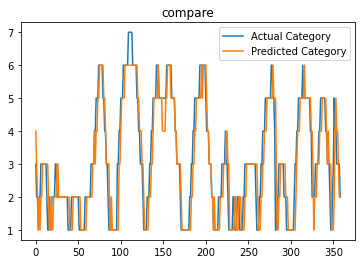

In [101]:
#Plot the Test Predictions

xi = list(range(len(actual_cat_test)))
plt.plot(xi,actual_cat_test, label='Actual Category')
plt.plot(xi,predicted_cat_test, label='Predicted Category')
plt.title('compare')
plt.legend() 